In [1]:
import os
os.chdir('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score 

import alpaca.utils.datasets.config as alpaca_config
alpaca_config.DATA_DIR = './datasets/alpaca_datasets'
from alpaca.ue import MCDUE
from alpaca.utils.datasets.builder import build_dataset
from alpaca.utils.ue_metrics import ndcg, uq_ll
from sklearn.model_selection import KFold

from scipy.special import logsumexp



from tqdm import tqdm

In [2]:
class MultilayerNN(nn.Module):
    """
    A Bayesian Neural Network model that uses dropout for uncertainty estimation.
    """
    def __init__(self, n_input: int, n_hidden: list, n_output: int, dropout_rate: float):
        """
        Initializes the BayesianNeuralNetwork.

        Parameters:
        -----------
        n_input : int
            Number of input features.
        n_hidden : list of int
            List containing the number of neurons in each hidden layer.
        n_output : int
            Number of output features.
        dropout_rate : float
            Dropout rate to be used in dropout layers.
        """
        super(MultilayerNN, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_input, n_hidden[0])])
        self.hidden_layers.extend([nn.Linear(n_hidden[i], n_hidden[i+1]) for i in range(len(n_hidden)-1)])
        self.output_layer = nn.Linear(n_hidden[-1], n_output)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor to the network.

        Returns:
        --------
        torch.Tensor
            Output tensor of the network after passing through all layers.
        """
        x = self.dropout(x)
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [3]:
def train(model: MultilayerNN, optimizer: torch.optim.Optimizer, criterion: nn.modules.loss, train_loader: DataLoader, epochs: int, tau: float, N: int) -> None:
    """
    Function to train the Bayesian Neural Network.

    Parameters:
    -----------
    model : BayesianNeuralNetwork
        The Bayesian neural network model to be trained.
    optimizer : torch.optim.Optimizer
        Optimizer used for training.
    criterion : torch.nn.modules.loss
        Loss function used for training.
    train_loader : DataLoader
        DataLoader containing the training data.
    epochs : int
        Number of epochs to train the model.
    tau : float
        Tau value used for regularization.
    N : int
        Total number of training samples.
    """
    model.train()
    losses = []
    for epoch in tqdm(range(epochs), desc='Epochs'):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            #loss += 1./(2.*N*tau) * sum([torch.sum(p.pow(2)) for p in model.parameters()])
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    return losses

def predict(model: MultilayerNN, x: torch.Tensor, mean_y:float, std_y:float ,T: int = 10000) -> tuple:
    """
    Make predictions with the trained Bayesian Neural Network.

    Parameters:
    -----------
    model : BayesianNeuralNetwork
        The trained Bayesian neural network model.
    x : torch.Tensor
        Input tensor for which the predictions are to be made.
    T : int, optional
        Number of stochastic forward passes for uncertainty estimation.

    Returns:
    --------
    Tuple[torch.Tensor, torch.Tensor]
        Mean and variance of the predictions.
    """
    model.train()
    
    with torch.no_grad():
        predictions = torch.stack([model(x) for _ in range(T)], dim=0)
        predictions = predictions * std_y + mean_y
        
        return predictions

In [4]:
dataset = build_dataset('kin8nm', val_split=1)
x_train_tmp, y_train_tmp = dataset.dataset('train')
x_val_tmp, y_val_tmp = dataset.dataset('val')
x_total = np.concatenate([x_train_tmp, x_val_tmp])
y_total = np.concatenate([y_train_tmp, y_val_tmp])

In [5]:
n_splits = 20
n_hidden = [50]  
n_output_features = y_total.shape[1]
n_input_features = x_total.shape[1]

dropout_rate = 0.05
tau = 250.0
n_epochs = 40
lengthscale = 1e-2
n_forward_passes = 10000


Fold: 0
Weight Decay: 2.441531739912619e-11


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s]


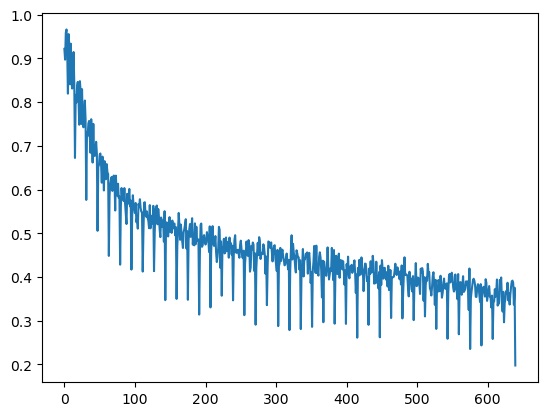

Average Gaussian Negative Log Likelihood: -0.1891034
Predictive Log Likelihood as in Gal et al.: 0.25906852
RMSE: 0.14234573

Fold: 1
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.10it/s]


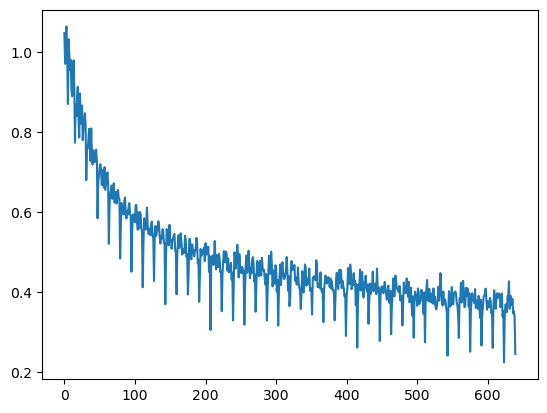

Average Gaussian Negative Log Likelihood: 0.02858005
Predictive Log Likelihood as in Gal et al.: 0.21535559
RMSE: 0.14919467

Fold: 2
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.98it/s]


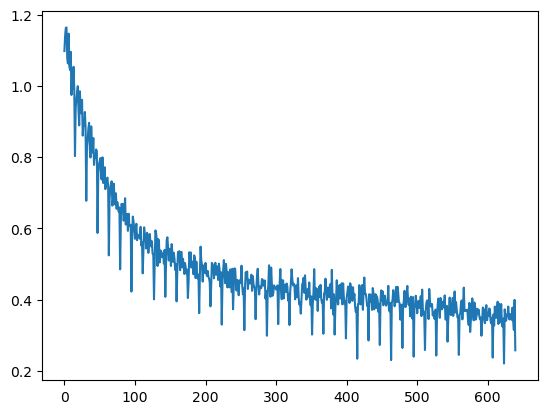

Average Gaussian Negative Log Likelihood: 0.6119507
Predictive Log Likelihood as in Gal et al.: 0.014657416
RMSE: 0.15005952

Fold: 3
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s]


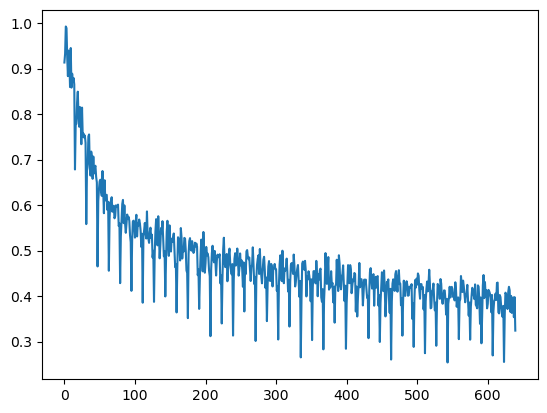

Average Gaussian Negative Log Likelihood: 0.6988427
Predictive Log Likelihood as in Gal et al.: 0.031021528
RMSE: 0.15669177

Fold: 4
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.92it/s]


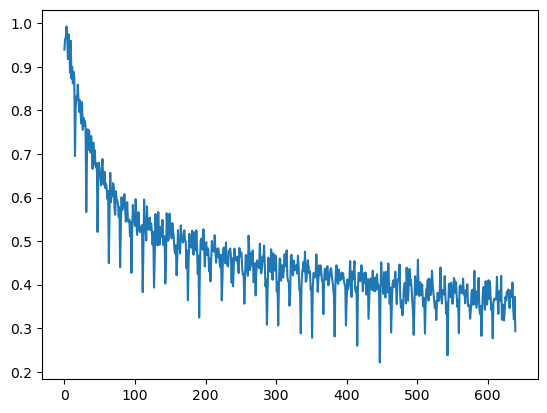

Average Gaussian Negative Log Likelihood: 0.1370246
Predictive Log Likelihood as in Gal et al.: 0.100087814
RMSE: 0.15298533

Fold: 5
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.96it/s]


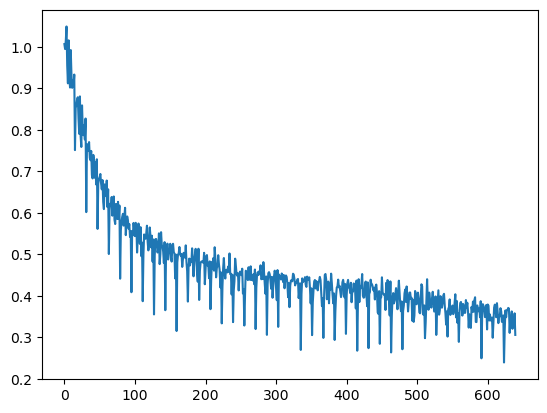

Average Gaussian Negative Log Likelihood: -0.50347924
Predictive Log Likelihood as in Gal et al.: 0.33699995
RMSE: 0.14009523

Fold: 6
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s]


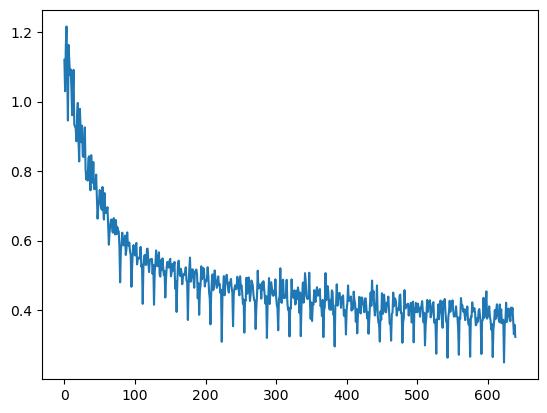

Average Gaussian Negative Log Likelihood: 0.2549352
Predictive Log Likelihood as in Gal et al.: 0.13346069
RMSE: 0.14889838

Fold: 7
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s]


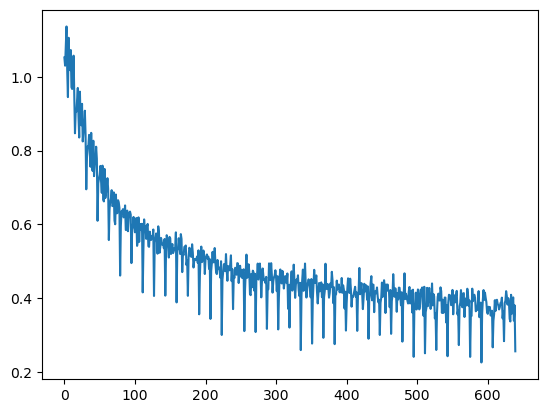

Average Gaussian Negative Log Likelihood: 0.037871916
Predictive Log Likelihood as in Gal et al.: 0.18771477
RMSE: 0.14891572

Fold: 8
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s]


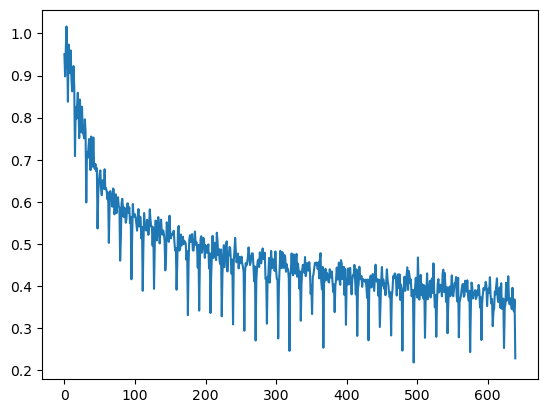

Average Gaussian Negative Log Likelihood: -0.035691526
Predictive Log Likelihood as in Gal et al.: 0.28072745
RMSE: 0.13882649

Fold: 9
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 15.86it/s]


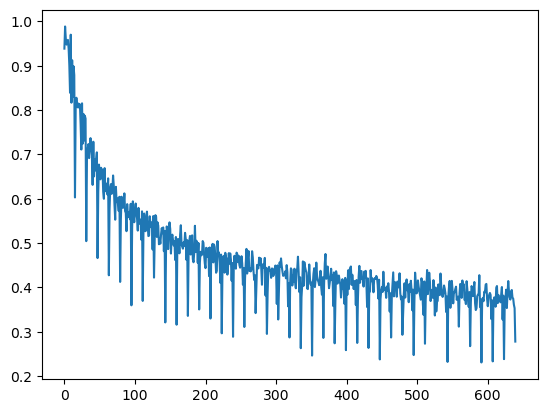

Average Gaussian Negative Log Likelihood: 0.28795072
Predictive Log Likelihood as in Gal et al.: 0.10755145
RMSE: 0.15017185

Fold: 10
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.61it/s]


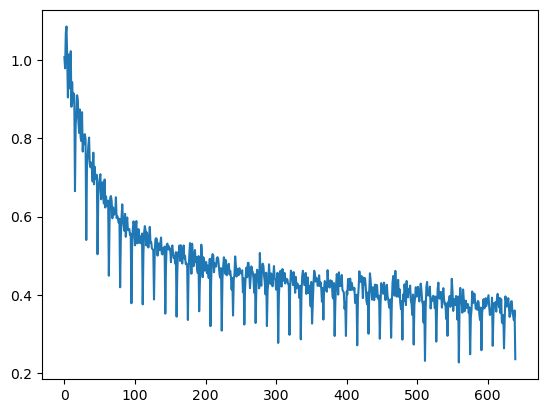

Average Gaussian Negative Log Likelihood: 0.31247455
Predictive Log Likelihood as in Gal et al.: 0.10795772
RMSE: 0.14976561

Fold: 11
Weight Decay: 2.441531739912619e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.59it/s]


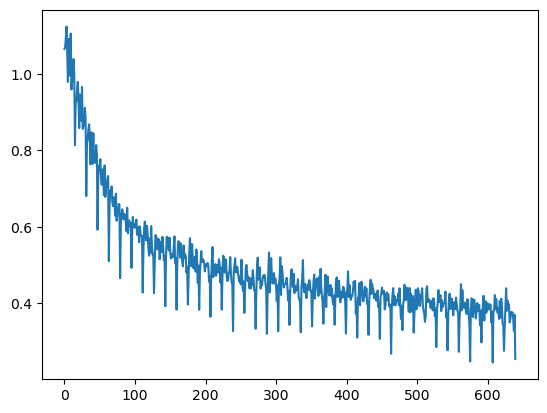

Average Gaussian Negative Log Likelihood: 0.57461536
Predictive Log Likelihood as in Gal et al.: 0.07055224
RMSE: 0.15396789

Fold: 12
Weight Decay: 2.441218039316459e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 15.25it/s]


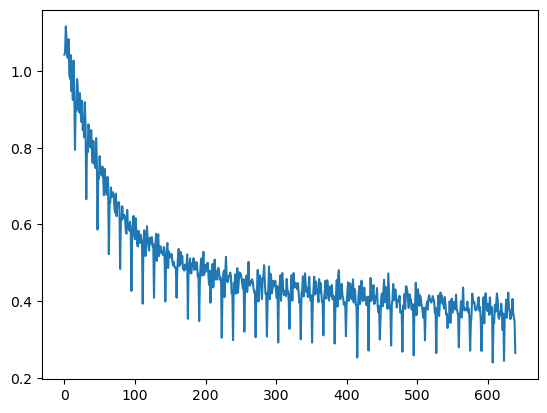

Average Gaussian Negative Log Likelihood: 0.0441842
Predictive Log Likelihood as in Gal et al.: 0.23368311
RMSE: 0.14449474

Fold: 13
Weight Decay: 2.441218039316459e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 14.98it/s]


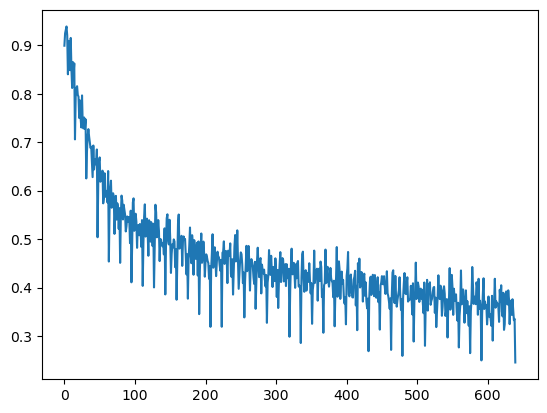

Average Gaussian Negative Log Likelihood: 0.04598968
Predictive Log Likelihood as in Gal et al.: 0.16888288
RMSE: 0.15181227

Fold: 14
Weight Decay: 2.441218039316459e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


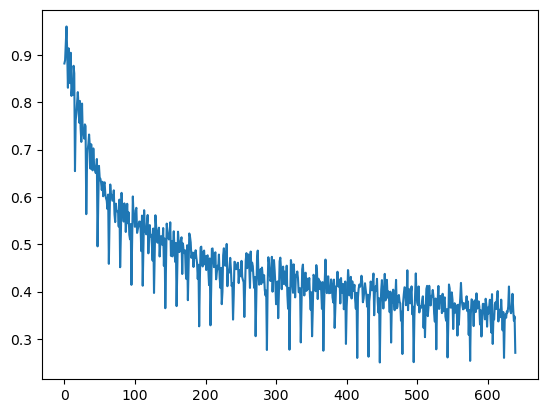

Average Gaussian Negative Log Likelihood: 0.1499388
Predictive Log Likelihood as in Gal et al.: 0.2078158
RMSE: 0.14507261

Fold: 15
Weight Decay: 2.441218039316459e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 14.43it/s]


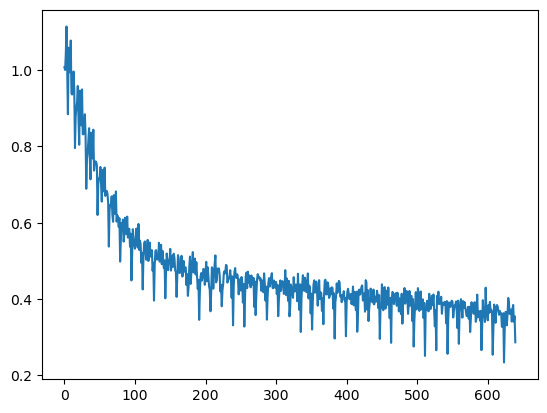

Average Gaussian Negative Log Likelihood: 0.16464972
Predictive Log Likelihood as in Gal et al.: 0.10394349
RMSE: 0.15041386

Fold: 16
Weight Decay: 2.441218039316459e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s]


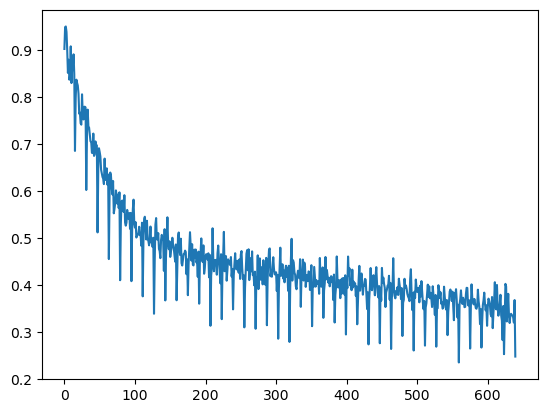

Average Gaussian Negative Log Likelihood: 0.1608928
Predictive Log Likelihood as in Gal et al.: 0.26389918
RMSE: 0.13923043

Fold: 17
Weight Decay: 2.441218039316459e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 16.44it/s]


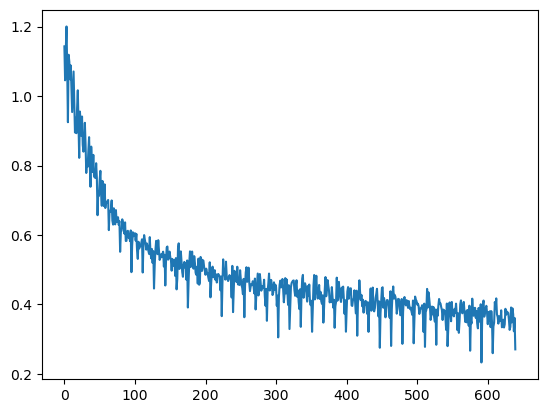

Average Gaussian Negative Log Likelihood: -0.094723575
Predictive Log Likelihood as in Gal et al.: 0.224976
RMSE: 0.14174765

Fold: 18
Weight Decay: 2.441218039316459e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s]


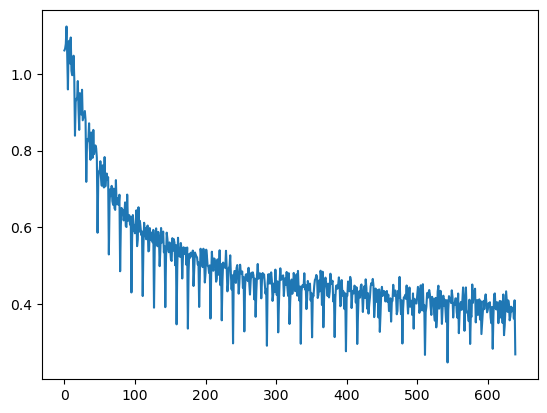

Average Gaussian Negative Log Likelihood: 0.111268155
Predictive Log Likelihood as in Gal et al.: 0.21171734
RMSE: 0.13717397

Fold: 19
Weight Decay: 2.441218039316459e-11


Epochs: 100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


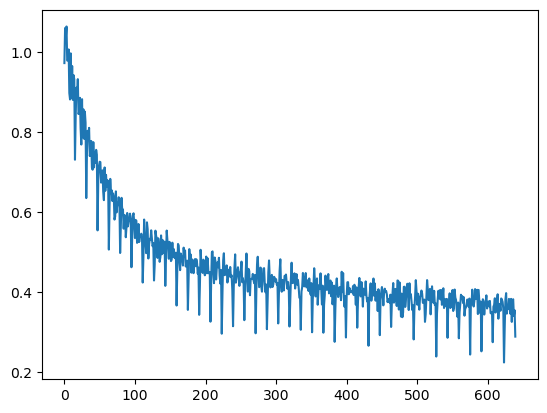

Average Gaussian Negative Log Likelihood: 0.0794344
Predictive Log Likelihood as in Gal et al.: 0.16268453
RMSE: 0.14879271


Total Results:
Gaussian NLLL: 0.14388028 +/- 0.26863778
RMSE: 0.14703283 +/- 0.00541346
Predictive Log Likelihood as in Gal et al.: 0.17113787 +/- 0.08402959


In [16]:


kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
ll_scores_cv = []
rmses_cv = []
gaussian_nll_scores_cv = []

for fold, (train_index, val_index) in enumerate(kf.split(x_total)):
    print("\nFold:", fold)
    x_train, y_train = x_total[train_index], y_total[train_index]
    x_val, y_val = x_total[val_index], y_total[val_index]

    n_input_samples = x_train.shape[0]
    weight_decay = lengthscale**2 * (1 - dropout_rate) / (2. * n_input_samples * tau)
    print(f"Weight Decay: {weight_decay}")

    mean_y = y_train.mean()
    std_y = y_train.std()

    y_train = (y_train - mean_y) / std_y #normalize

    train_ds = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    val_ds = TensorDataset(torch.FloatTensor(x_val), torch.FloatTensor(y_val))
    train_loader = DataLoader(train_ds, batch_size=512)
    val_loader = DataLoader(val_ds, batch_size=512)


    model = MultilayerNN(n_input_features, n_hidden, n_output_features, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
    criterion = nn.MSELoss()
    eval_criterion = nn.GaussianNLLLoss(reduction='none')

    losses = train(model, optimizer, criterion, train_loader, n_epochs, tau, len(train_ds))

    plt.plot(losses)
    plt.show()


    # Evaluate the model
    scoring_list = []
    ll_list = []
    square_error_list = []

    with torch.no_grad():
        # Iterate over the validation set
        for x_batch, y_batch in val_loader:

            predictions = predict(model, x_batch, mean_y, std_y, T=n_forward_passes)
            mean_pred = predictions.mean(dim=0)
            var_pred = predictions.var(dim=0)

            ll = (logsumexp(-0.5 * tau * (predictions - y_batch)**2., 0) - np.log(n_forward_passes) 
                - 0.5*np.log(2*np.pi) - 0.5*np.log(1/tau)).flatten()
            # Here you can calculate RMSE, log-likelihood, or any other metric as needed
            scoring_list.append(eval_criterion(mean_pred, y_batch, var_pred))
            ll_list.append(ll)
            square_error_list.append((mean_pred - y_batch)**2.)

    cat_scores = np.concatenate(scoring_list)
    lls = np.concatenate(ll_list)
    square_errors = np.concatenate(square_error_list)

    ll_score = np.mean(lls)
    score = np.mean(cat_scores)
    rmse = np.sqrt(np.mean(square_errors))


    gaussian_nll_scores_cv.append(score)
    rmses_cv.append(rmse)
    ll_scores_cv.append(ll_score)
    print("Average Gaussian Negative Log Likelihood:", score)
    print("Predictive Log Likelihood as in Gal et al.:", ll_score)
    print("RMSE:", rmse)
print("\n\nTotal Results:")
print("Gaussian NLLL:", np.mean(gaussian_nll_scores_cv), "+/-", np.std(gaussian_nll_scores_cv))
print("RMSE:", np.mean(rmses_cv), "+/-", np.std(rmses_cv))
print("Predictive Log Likelihood as in Gal et al.:", np.mean(ll_scores_cv), "+/-", np.std(ll_scores_cv))

In [7]:
(-0.5 * tau * (predictions - y_batch)**2.).shape

torch.Size([10000, 409, 8])

In [8]:
predictions.shape, y_batch.shape

(torch.Size([10000, 409, 1]), torch.Size([409, 1]))

In [15]:
logsumexp(-0.5 * tau * (predictions - y_batch)**2., 0).shape

(409, 1)

In [14]:
(predictions - y_batch)[2,0]

tensor([0.1472])

In [21]:
len(train_index)

7783